This notebook implements an LSTM to predict the pollution levels
for the next hour from the weather conditions and pollution levels
in the current hour.

The dataset used is the `Beijing PM2.5` dataset available
[here](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

In [1]:
# Import all packages required

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For building the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense

# For evaluating the model
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## 1. Import data 

In [2]:
# Import data
df = pd.read_csv('data/pollution.csv')

df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## 2. Data Preprocessing

In [3]:
# Set the index to the timestamp of the row
df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour']], format='%Y %m %d %H')

# Drop unrequired columns
df = df.drop(columns=['No', 'year', 'month', 'day', 'hour'])

# Rename columns to make it easier to understand
df = df.rename(columns={'pm2.5': 'pollution',
                       'DEWP': 'dew_point',
                       'TEMP': 'temperature',
                       'PRES': 'pressure',
                       'cbwd': 'wind_direction',
                       'Iws': 'wind_speed',
                       'Is': 'snow',
                       'Ir': 'rain'})

# The first 24 records have null pollution values
df = df[24:]

# Fill the other NA values in the pollution column to 0
# This is required during scaling
df = df.fillna(0)

df.head()

,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,snow,rain
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
# Encode the wind_direction column
label_encoder = LabelEncoder()
df['wind_direction'] = label_encoder.fit_transform(df['wind_direction'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1145154e0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1139533c8>], dtype=object)

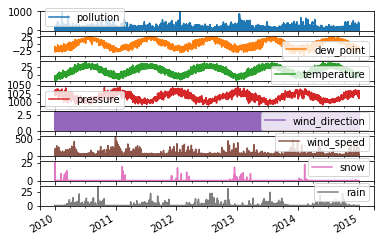

In [5]:
# A simple plot to visualize the correlation between the columns
df.plot(subplots=True)

In [6]:
# Scale the values in the dataframe to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df)

In [7]:
# Construct a DataFrame from the scaled 2d array
data = pd.DataFrame(values)

data.columns = df.columns
data.index = df.index

data.head()

,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,snow,rain
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0


To use supervised learning on the dataset, the pollution for the
next hour is considered to be the output.

In [8]:
# Shift the pollution column up to create the output variable
data['predicted_pollution'] = data['pollution'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
data = data.drop(data.tail(1).index)

data.head()

,pollution,dew_point,temperature,pressure,wind_direction,wind_speed,snow,rain,predicted_pollution
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


## 3. Define and fit LSTM model

### 3.1 Create the training and testing datasets and separate the input and output

In [9]:
# Split the dataset into training and testing datasets
# The first yesr is used as training data
train = data.values[:365 * 24]
test = data.values[365 * 24:]

# Separate input and output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Print all shapes
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

### 3.2 Define the LSTM Model

In [10]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50,
                    batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 3s - loss: 0.0619 - val_loss: 0.0552
Epoch 2/50
 - 2s - loss: 0.0386 - val_loss: 0.0617
Epoch 3/50
 - 2s - loss: 0.0246 - val_loss: 0.0445
Epoch 4/50
 - 2s - loss: 0.0180 - val_loss: 0.0342
Epoch 5/50
 - 2s - loss: 0.0155 - val_loss: 0.0203
Epoch 6/50
 - 2s - loss: 0.0148 - val_loss: 0.0160
Epoch 7/50
 - 2s - loss: 0.0146 - val_loss: 0.0149
Epoch 8/50
 - 2s - loss: 0.0147 - val_loss: 0.0146
Epoch 9/50
 - 2s - loss: 0.0147 - val_loss: 0.0145
Epoch 10/50
 - 2s - loss: 0.0146 - val_loss: 0.0145
Epoch 11/50
 - 2s - loss: 0.0145 - val_loss: 0.0142
Epoch 12/50
 - 2s - loss: 0.0145 - val_loss: 0.0140
Epoch 13/50
 - 2s - loss: 0.0145 - val_loss: 0.0138
Epoch 14/50
 - 2s - loss: 0.0145 - val_loss: 0.0136
Epoch 15/50
 - 2s - loss: 0.0145 - val_loss: 0.0136
Epoch 16/50
 - 2s - loss: 0.0145 - val_loss: 0.0136
Epoch 17/50
 - 2s - loss: 0.0145 - val_loss: 0.0136
Epoch 18/50
 - 2s - loss: 0.0144 - val_loss: 0.0135
Epoch 19/50
 - 2s - loss

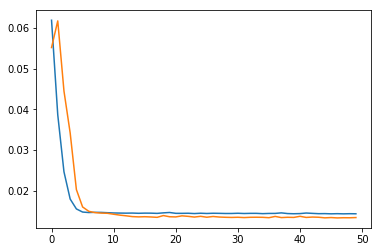

In [11]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

### 3.3 Evalute the Model

In [12]:
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
'{:.3f}'.format(rmse)

'26.483'

### Results

The Notebook trains the model on the data from the first year.
Training on more data will improve the model.